<a href="https://colab.research.google.com/github/Masakinka/python_for_ds_task/blob/main/HW_2_4_%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D0%B8_%D0%B1%D1%83%D1%81%D1%82%D0%B8%D0%BD%D0%B3%D1%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [1]:
 # Підключення Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
!pip install hyperopt --quiet

In [4]:
import opendatasets as od
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
from typing import Tuple, Dict, Any

import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


In [5]:
pd.set_option('display.max.rows',130)
pd.set_option('display.max.columns',130)
pd.set_option('float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [6]:
# Завантаження даних з Kaggle
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu/'
od.download(dataset_url)
data_dir = './bank-customer-churn-prediction-dlu'
raw_df = pd.read_csv('./bank-customer-churn-prediction-dlu/train.csv')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: viktoriiabortnikova
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 46.7MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu/bank-customer-churn-prediction-dlu.zip to ./bank-customer-churn-prediction-dlu


In [7]:
def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [8]:
target_column = 'Exited'
input_columns = raw_df.columns.difference([target_column]).tolist()

train_df, val_df = split_train_val(raw_df, target_col=target_column)
train_inputs, train_targets = separate_inputs_targets(train_df, input_cols=input_columns, target_col=target_column)
val_inputs, val_targets = separate_inputs_targets(val_df, input_cols=input_columns, target_col=target_column)

# Виведення результатів для перевірки
print("Train inputs:")
print(train_inputs.head())
print("Train targets:")
print(train_targets.head())
print("Validation inputs:")
print(val_inputs.head())
print("Validation targets:")
print(val_targets.head())

Train inputs:
        Age   Balance  CreditScore  CustomerId  EstimatedSalary  Gender Geography  HasCrCard  IsActiveMember  NumOfProducts    Surname  Tenure     id
7180  30.00 131394.56       682.00 15652218.00        143952.24    Male    France       1.00            1.00           1.00       Mays    1.00   7180
10393 39.00 178058.06       684.00 15592937.00        145518.31  Female    France       1.00            0.00           1.00     Ch'eng    2.00  10393
80    35.00 116320.68       705.00 15774586.00        174431.01    Male   Germany       1.00            0.00           2.00      Ch'in    6.00     80
3365  58.00      0.00       669.00 15780572.00         51565.98    Male     Spain       0.00            1.00           2.00         K?    0.00   3365
12236 21.00      0.00       707.00 15642099.00        148564.76    Male    France       1.00            1.00           2.00  Trevisani    3.00  12236
Train targets:
7180    0.00
10393   0.00
80      0.00
3365    0.00
12236   0.00
Name: 

1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [9]:
# Визначення категоріальних колонок
categorical_columns = raw_df.select_dtypes(include=['object']).columns.tolist()
categorical_columns

['Surname', 'Geography', 'Gender']

In [10]:
# Перетворення категоріальних ознак на тип category
#for col in categorical_columns:
#    train_inputs[col] = train_inputs[col].astype('category')
#    val_inputs[col] = val_inputs[col].astype('category')

# Альтернативний спосіб використання pd.Categorical
for col in categorical_columns:
    train_inputs[col] = pd.Categorical(train_inputs[col])
    val_inputs[col] = pd.Categorical(val_inputs[col])

# Виведення результатів для перевірки
print("Train inputs:")
print(train_inputs.dtypes)
print("Validation inputs:")
print(val_inputs.dtypes)

Train inputs:
Age                 float64
Balance             float64
CreditScore         float64
CustomerId          float64
EstimatedSalary     float64
Gender             category
Geography          category
HasCrCard           float64
IsActiveMember      float64
NumOfProducts       float64
Surname            category
Tenure              float64
id                    int64
dtype: object
Validation inputs:
Age                 float64
Balance             float64
CreditScore         float64
CustomerId          float64
EstimatedSalary     float64
Gender             category
Geography          category
HasCrCard           float64
IsActiveMember      float64
NumOfProducts       float64
Surname            category
Tenure              float64
id                    int64
dtype: object


2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [11]:
# Тренування моделі XGBClassifier
xgb_clf = XGBClassifier(
    use_label_encoder=False,  # щоб уникнути попереджень, якщо використовуєте нові версії XGBoost
    missing=np.nan,  # явне вказування пропущених значень
    enable_categorical=True,  # Обробка категоріальних колонок
    random_state=42,  # Випадковий стан для відтворюваності результатів
    device='cuda',
    max_depth=3,
    n_estimators=10
)

xgb_clf.fit(train_inputs, train_targets)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:49:22] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [12]:
# Прогнозування на тренувальному та валідаційному наборах
train_preds = xgb_clf.predict_proba(train_inputs)[:, 1]
val_preds = xgb_clf.predict_proba(val_inputs)[:, 1]

# Вимірювання точності з допомогою AUROC
train_auc = roc_auc_score(train_targets, train_preds)
val_auc = roc_auc_score(val_targets, val_preds)

print(f"Train AUROC: {train_auc}")
print(f"Validation AUROC: {val_auc}")

Train AUROC: 0.9421334105891545
Validation AUROC: 0.9251563893271144


In [13]:
train_pred = xgb_clf.predict(train_inputs)
val_pred = xgb_clf.predict(val_inputs)

print(classification_report(train_targets, train_pred, digits=4))
print(classification_report(val_targets, val_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.9162    0.9684    0.9416      9558
         1.0     0.8408    0.6532    0.7352      2442

    accuracy                         0.9042     12000
   macro avg     0.8785    0.8108    0.8384     12000
weighted avg     0.9008    0.9042    0.8996     12000

              precision    recall  f1-score   support

         0.0     0.9047    0.9653    0.9340      2390
         1.0     0.8156    0.6016    0.6925       610

    accuracy                         0.8913      3000
   macro avg     0.8601    0.7835    0.8132      3000
weighted avg     0.8866    0.8913    0.8849      3000



Для класу 1 (меншості) на тренувальному наборі модель досягає значення 0.6532, тоді як на валідаційному лише 0.6016.Зниження F1-score на валідаційній вибірці в порівнянні з тренувальною також вказує на те, що модель може бути перенавчена на тренувальних даних. Існують ознаки переобучення, але вони незначні. Модель демонструє кращі результати на тренувальній вибірці



**Висновки**:
Результати AUROC на тренувальній та валідаційній вибірках досить близькі (0.942 проти 0.925), що свідчить про добре збалансовану модель.
Враховуючи високі значення AUROC на обох наборах, можна сказати, що модель не страждає від High Bias (низька точність) або High Variance (перенавчання).
Модель XGBClassifier є більш точною та збалансованою, ніж Decision Trees, але покращення не є радикальним.

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [29]:
def objective(params):
    clf = xgb.XGBClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        gamma=params['gamma'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        enable_categorical=True,
        use_label_encoder=False,
        missing=np.nan,
      #  device='cuda',
        early_stopping_rounds=10
    )
    clf.fit(
        train_inputs,
        train_targets,
        eval_set=[(val_inputs, val_targets)],
        eval_metric="auc",
        verbose=False
    )

    pred = clf.predict_proba(val_inputs)[:, 1]
    auc = roc_auc_score(val_targets, pred)

    return {'loss': -auc, 'status': STATUS_OK}

In [31]:
# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



  5%|▌         | 1/20 [00:01<00:25,  1.35s/trial, best loss: -0.9332447355785719]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 10%|█         | 2/20 [00:02<00:22,  1.25s/trial, best loss: -0.9332447355785719]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 15%|█▌        | 3/20 [00:02<00:13,  1.27trial/s, best loss: -0.9332447355785719]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 25%|██▌       | 5/20 [00:03<00:06,  2.23trial/s, best loss: -0.9341072775910557]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 35%|███▌      | 7/20 [00:03<00:04,  3.12trial/s, best loss: -0.9366544344605253]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 40%|████      | 8/20 [00:04<00:03,  3.18trial/s, best loss: -0.9366544344605253]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 45%|████▌     | 9/20 [00:04<00:03,  3.32trial/s, best loss: -0.9366544344605253]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 50%|█████     | 10/20 [00:04<00:02,  3.66trial/s, best loss: -0.9366544344605253]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 55%|█████▌    | 11/20 [00:04<00:02,  3.83trial/s, best loss: -0.9366544344605253]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 65%|██████▌   | 13/20 [00:05<00:01,  3.61trial/s, best loss: -0.9366544344605253]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 70%|███████   | 14/20 [00:06<00:04,  1.48trial/s, best loss: -0.9366544344605253]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 75%|███████▌  | 15/20 [00:08<00:04,  1.09trial/s, best loss: -0.9369092530351875]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 85%|████████▌ | 17/20 [00:09<00:02,  1.39trial/s, best loss: -0.9369092530351875]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 90%|█████████ | 18/20 [00:09<00:01,  1.76trial/s, best loss: -0.9369092530351875]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



 95%|█████████▌| 19/20 [00:10<00:00,  2.07trial/s, best loss: -0.9369092530351875]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



100%|██████████| 20/20 [00:10<00:00,  1.90trial/s, best loss: -0.9369092530351875]
Найкращі гіперпараметри:  {'colsample_bytree': 0.6762631141197977, 'gamma': 0.4680434822912656, 'learning_rate': 0.11645950195845559, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 125, 'reg_alpha': 0.051228249232658674, 'reg_lambda': 0.3837623843846182, 'subsample': 0.6049314496241731}


In [33]:
best

{'colsample_bytree': 0.6762631141197977,
 'gamma': 0.4680434822912656,
 'learning_rate': 0.11645950195845559,
 'max_depth': 6,
 'min_child_weight': 7,
 'n_estimators': 125,
 'reg_alpha': 0.051228249232658674,
 'reg_lambda': 0.3837623843846182,
 'subsample': 0.6049314496241731}

In [34]:
# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = xgb.XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    use_label_encoder=False,
    missing=np.nan,
    device='cpu',  # Використовуйте CPU
    eval_metric="auc"
)

final_clf.fit(train_inputs, train_targets)
train_preds = final_clf.predict_proba(train_inputs)[:, 1]
val_preds = final_clf.predict_proba(val_inputs)[:, 1]

train_auc = roc_auc_score(train_targets, train_preds)
val_auc = roc_auc_score(val_targets, val_preds)

print(f"Train AUROC: {train_auc:.4f}")
print(f"Validation AUROC: {val_auc:.4f}")

# Оцінка моделі з використанням classification_report
train_pred = final_clf.predict(train_inputs)
val_pred = final_clf.predict(val_inputs)

print(classification_report(train_targets, train_pred, digits=4))
print(classification_report(val_targets, val_pred, digits=4))

Train AUROC: 0.9700
Validation AUROC: 0.9325
              precision    recall  f1-score   support

         0.0     0.9433    0.9742    0.9585      9558
         1.0     0.8840    0.7707    0.8235      2442

    accuracy                         0.9327     12000
   macro avg     0.9136    0.8724    0.8910     12000
weighted avg     0.9312    0.9327    0.9310     12000

              precision    recall  f1-score   support

         0.0     0.9188    0.9519    0.9351      2390
         1.0     0.7805    0.6705    0.7213       610

    accuracy                         0.8947      3000
   macro avg     0.8497    0.8112    0.8282      3000
weighted avg     0.8907    0.8947    0.8916      3000



Модель final_clf з оптимізованими гіперпараметрами показала кращу якість порівняно з попередньою моделлю.
- Покращення AUROC на тренувальній вибірці: 0.9700 проти 0.9421;
- Покращення AUROC на валідаційній вибірці: 0.9325 проти 0.9251

Таким чином, оптимізація гіперпараметрів дозволила покращити якість моделі, особливо на тренувальній вибірці, при цьому модель не демонструє значного переобучення, оскільки покращення AUROC на валідаційній вибірці також наявне.

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [35]:
%%bash
sudo apt-get update
sudo apt-get install -y build-essential cmake git wget unzip
sudo apt-get install -y libboost-dev libboost-system-dev libboost-filesystem-dev
sudo apt-get install -y libboost-iostreams-dev libboost-program-options-dev libboost-regex-dev
sudo apt-get install -y libboost-thread-dev libboost-chrono-dev libboost-date-time-dev
sudo apt-get install -y libboost-atomic-dev libboost-serialization-dev
sudo apt-get install -y python3-pip

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,073 kB]
Hit:13 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:14 http://security.ubuntu.com/ub

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [36]:
%%bash
sudo apt-get install -y ocl-icd-libopencl1 clinfo
sudo apt-get install -y nvidia-opencl-dev opencl-headers

Reading package lists...
Building dependency tree...
Reading state information...
clinfo is already the newest version (3.0.21.02.21-1).
ocl-icd-libopencl1 is already the newest version (2.2.14-3).
ocl-icd-libopencl1 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 46 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
nvidia-opencl-dev is already the newest version (11.5.1-1ubuntu1).
The following NEW packages will be installed:
  opencl-headers
0 upgraded, 1 newly installed, 0 to remove and 46 not upgraded.
Need to get 1,754 B of archives.
After this operation, 12.3 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 opencl-headers all 3.0~2022.01.04-1 [1,754 B]
Fetched 1,754 B in 0s (11.6 kB/s)
Selecting previously unselected package opencl-headers.
(Reading database ... 124451 files and directories currently installed.)
Preparing to unpack .../opencl-headers_3.0~20

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [37]:
%%bash
git clone --recursive https://github.com/microsoft/LightGBM
cd LightGBM
mkdir build
cd build
cmake -DUSE_CUDAP=1 ..
make -j4

Process is interrupted.


In [39]:
import lightgbm as lgb
print(lgb.__version__)

4.1.0


In [41]:
cat_feature_indexes = [train_inputs.columns.get_loc(col) for col in categorical_columns]

In [44]:
lgb_clf = lgb.LGBMClassifier(
    max_depth=3,
    n_estimators=50,
    learning_rate=0.1,
    cat_feature=cat_feature_indexes,  # для автоматичного розпізнавання категорійних ознак
    missing=np.nan,  # явне вказування пропущених значень
    # device='cuda'  # використовувати GPU для прискорення обчислень
)

# Навчання моделі
lgb_clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])

# Прогнозування та оцінка якості
train_preds = lgb_clf.predict_proba(train_inputs)[:, 1]
val_preds = lgb_clf.predict_proba(val_inputs)[:, 1]

train_auc = roc_auc_score(train_targets, train_preds)
val_auc = roc_auc_score(val_targets, val_preds)

print(f"Train AUROC: {train_auc:.4f}")
print(f"Validation AUROC: {val_auc:.4f}")

# Оцінка моделі з використанням classification_report
train_pred = lgb_clf.predict(train_inputs)
val_pred = lgb_clf.predict(val_inputs)

[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set with cat_feature=10,6,5, categorical_column=5,6,10 will be ignored. Current value: categorical_feature=10,6,5
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1826
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 13
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pa

Модель має високі значення AUROC як на тренувальній, так і на валідаційній вибірках (0.9501 та 0.9355 відповідно). Це свідчить про те, що модель добре навчається на тренувальних даних і не має значної упередженості (bias).

 Різниця між AUROC на тренувальній та валідаційній вибірках незначна (0.9501 проти 0.9355), що свідчить про те, що модель не страждає від сильної варіативності (variance).

Загальна оцінка:
Модель є хорошою. Значення AUROC більше 0.9 на обох вибірках свідчать про те, що модель добре розрізняє класи.
Немає ознак high bias або high variance, бо модель добре збалансована і показує хороші результати як на тренувальній, так і на валідаційній вибірках.
А метрики F1-score, precision та recall також свідчать про хорошу якість моделі, хоча recall для класу 1 можна покращити.

**Висновок**: Модель LightGBM показує трохи кращий результат на валідаційній вибірці (0.9355) порівняно з XGBoost (0.9325). Однак на тренувальній вибірці LightGBM (0.9501) поступається XGBoost (0.9700).

Загальна точність моделі LightGBM на валідаційній вибірці (0.8987) трохи вища за точність XGBoost (0.8947).
Precision і Recall для класу 1 в LightGBM нижчі, ніж у XGBoost, що свідчить про те, що модель LightGBM краще підходить для класу 0.

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [63]:
# Функція objective
def objective(params, train_inputs, train_targets, val_inputs, val_targets):
    # Забезпечення, що num_leaves >= 2^max_depth
    num_leaves = int(params['num_leaves'])
    max_depth = int(params['max_depth'])
    if num_leaves < 2 ** max_depth:
        num_leaves = 2 ** max_depth

    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=max_depth,
        num_leaves=num_leaves,
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        max_bin=int(params['max_bin']),
        categorical_feature=params['cat_feature'],
        missing=np.nan
    )

    clf.fit(
        train_inputs,
        train_targets,
        eval_set=[(val_inputs, val_targets)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
    )

    pred = clf.predict_proba(val_inputs)[:, 1]
    auc = roc_auc_score(val_targets, pred)

    return {'loss': -auc, 'status': STATUS_OK}

In [66]:
# Простір гіперпараметрів
param_space = {
    'num_leaves': hp.choice('num_leaves', range(31, 151, 10)),
    'max_depth': hp.choice('max_depth', range(0, 15, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'n_estimators': hp.choice('n_estimators', range(50, 501, 50)),
    'min_child_weight': hp.uniform('min_child_weight', 1, 10),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'max_bin': hp.choice('max_bin', range(100, 256, 10)),
    'cat_feature': hp.choice('cat_feature', [cat_feature_indexes])
}

# Оптимізація
trials = Trials()
best_params = fmin(
    fn=lambda params: objective(params, train_inputs, train_targets, val_inputs, val_targets),
    space=param_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=trials
)

# Перетворення значень гіперпараметрів у кінцеві типи
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_bin'] = int(best_params['max_bin'])

# Забезпечення, що num_leaves >= 2 ** max_depth
if best_params['num_leaves'] < 2 ** best_params['max_depth']:
    best_params['num_leaves'] = 2 ** best_params['max_depth']

print("Найкращі гіперпараметри: ", best_params)

[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] categorical_feature is set=10,6,5, categorical_column=5,6,10 will be ignored. Current value: categorical_feature=10,6,5
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1257
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 13
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1893: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1893: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in p

[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] categorical_feature is set=10,6,5, categorical_column=5,6,10 will be ignored. Current value: categorical_feature=10,6,5
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
 10%|█         | 1/10 [00:00<00:04,  2.24trial/s, best loss: -0.9217456615680089]

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1893: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1107
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 13
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1893: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] Categorical features with more bins than the configured ma

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1893: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')



[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1606
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 13
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1893: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
 30%|███       | 3/10 [00:02<00:05,  1.36trial/s, best loss: -0.9362548871664723]

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1893: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')



[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] categorical_feature is set=10,6,5, categorical_column=5,6,10 will be ignored. Current value: categorical_feature=10,6,5
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1802
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 13
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1893: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1893: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')



[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 13
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
 40%|████      | 4/10 [00:04<00:06,  1.14s/trial, best loss: -0.9362548871664723]

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1893: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1893: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')



[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 13
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
 50%|█████     | 5/10 [00:05<00:05,  1.20s/trial, best loss: -0.9362548871664723]

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1893: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1893: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1893: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1893: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')



[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] categorical_feature is set=10,6,5, categorical_column=5,6,10 will be ignored. Current value: categorical_feature=10,6,5
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1057
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 13
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
                                                                                 

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1893: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1893: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1893: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in p

[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] categorical_feature is set=10,6,5, categorical_column=5,6,10 will be ignored. Current value: categorical_feature=10,6,5
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1107
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 13
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [In

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1893: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1893: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in p

[LightGBM] [Warning] Unknown parameter: missing
100%|██████████| 10/10 [00:09<00:00,  1.05trial/s, best loss: -0.9369260580286715]
Найкращі гіперпараметри:  {'cat_feature': 0, 'colsample_bytree': 0.5399162954612313, 'learning_rate': 0.4344941851042041, 'max_bin': 0, 'max_depth': 2, 'min_child_weight': 4.400358191640906, 'n_estimators': 6, 'num_leaves': 7, 'reg_alpha': 0.26521967262019397, 'reg_lambda': 0.049987308645515816, 'subsample': 0.8505218133966631}


In [69]:
# Корекція гіперпараметрів
if best_params['n_estimators'] < 10:
    best_params['n_estimators'] = 50
if best_params['max_bin'] == 0:
    best_params['max_bin'] = 255

# Створення фінальної моделі з найкращими гіперпараметрами
final_lgb_clf = lgb.LGBMClassifier(
    num_leaves=best_params['num_leaves'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    max_bin=best_params['max_bin']
)

# Навчання моделі
final_lgb_clf.fit(train_inputs, train_targets)

# Оцінка на тренувальній вибірці
#train_pred = final_lgb_clf.predict_proba(train_inputs)[:, 1]
# train_roc_auc = roc_auc_score(train_targets, train_pred)
train_pred_proba = final_lgb_clf.predict_proba(train_inputs)[:, 1]
train_pred = (train_pred_proba > 0.5).astype(int)
train_roc_auc = roc_auc_score(train_targets, train_pred_proba)

# Оцінка на валідаційній вибірці
#val_pred = final_lgb_clf.predict_proba(val_inputs)[:, 1]
#val_roc_auc = roc_auc_score(val_targets, val_pred)
val_pred_proba = final_lgb_clf.predict_proba(val_inputs)[:, 1]
val_pred = (val_pred_proba > 0.5).astype(int)
val_roc_auc = roc_auc_score(val_targets, val_pred_proba)

print(f"AUROC на тренувальній вибірці: {train_roc_auc}")
print(f"AUROC на валідаційній вибірці: {val_roc_auc}")

# Виведення звіту класифікації для тренувальної вибірки
print("Звіт класифікації на тренувальній вибірці:")
print(classification_report(train_targets, train_pred, digits=4))

# Виведення звіту класифікації для валідаційної вибірки
print("Звіт класифікації на валідаційній вибірці:")
print(classification_report(val_targets, val_pred, digits=4))

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1826
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
AUROC на тренувальній вибірці: 0.9530393259206817
AUROC на валідаційній вибірці: 0.9366873585293916
Звіт класифікації на тренувальній вибірці:
              precision    recall  f1-score   support

         0.0   

Загальні висновки:
Модель з оптимізованими гіперпараметрами має трохи вищий AUROC як на тренувальній (0.9530 проти 0.9501), так і на валідаційній вибірках (0.9367 проти 0.9355). Це свідчить про кращу здатність моделі 1 розрізняти класи.

Обидві моделі показують високі значення precision та recall для класу 0. Для класу 1, модель з оптимізованими гіперпараметрами має трохи кращі показники recall на тренувальній вибірці (0.7072 проти 0.6884) та трохи гірші на валідаційній вибірці (0.6672 проти 0.6590). Значення precision для класу 1 в обох моделях майже однакові.

Обидві моделі показують добре збалансовані результати між тренувальною та валідаційною вибірками, що свідчить про відсутність значної переучення (bias) або недостатнього навчання (variance).


**Висновок**
Модель LightGBM з оптимізованими гіперпараметрами показує трохи кращий результат на валідаційній вибірці порівняно з попередньою моделлю. Значення AUROC, precision, recall та f1-score для класу 1 є трохи кращими у порівнянні з попередньою моделлю, що свідчить про кращу загальну продуктивність моделі з оптимізованими гіперпараметрами.

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

 Обраю модель LightGBM після оптимізації гіперпараметрів, оскільки вона показала найкращі результати на валідаційній вибірці з найвищим значенням AUROC та добре збалансованими значеннями precision та recall для обох класів. Ця модель має найкращу загальну продуктивність і демонструє, що оптимізація гіперпараметрів значно покращила її здатність розрізняти класи.

In [72]:
# Підготовка даних для сабмішну
# Завантаження тестових даних
test_df = pd.read_csv('./bank-customer-churn-prediction-dlu/test.csv')

# Переконайтесь, що тестові дані мають ті ж самі колонки, що й тренувальні дані
train_columns = train_inputs.columns
for col in train_columns:
    if col not in test_df.columns:
        test_df[col] = 0  # або будь-яке відповідне значення за замовчуванням

# Переконайтесь, що порядок колонок збігається
test_inputs = test_df[train_columns]

# Перетворення категоріальних колонок у той самий тип, що й у тренувальних даних
for col in categorical_columns:
    test_inputs[col] = pd.Categorical(test_inputs[col], categories=train_inputs[col].cat.categories)

# Прогнозування з використанням фінальної моделі LightGBM
test_preds = final_lgb_clf.predict_proba(test_inputs)[:, 1]

# Підготовка файлу для сабмішну
submission_df = pd.DataFrame({'id': test_df['id'], 'Exited': test_preds})

# Збереження оновленого DataFrame у новий CSV файл
submission_df.to_csv('drive/MyDrive/Colab Notebooks/data//submission_light_opt.csv', index=False)

In [73]:
submission_df.head()

,id,Exited
0,15000,0.04
1,15001,0.01
2,15002,0.05
3,15003,0.74
4,15004,0.03


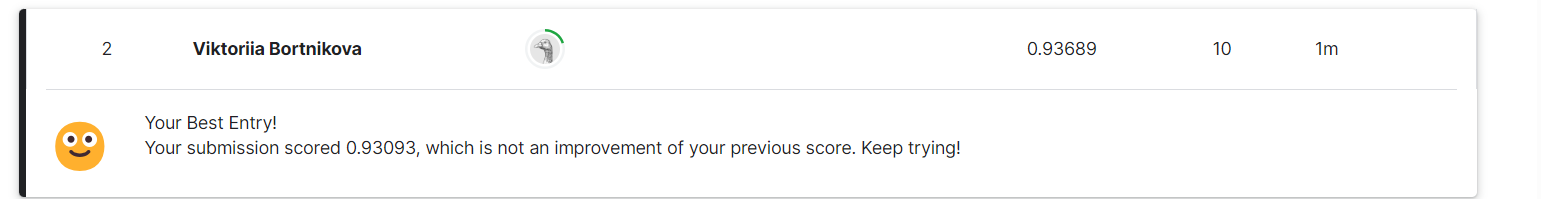

Модель Логістичної регресії з поліноміальними ознаками показала кращі результати порівняно з моделлю LightGBM з оптимізованими гіперпараметрами. Це може бути обумовлено кількома факторами:
1. Поліноміальні ознаки дозволяють моделі враховувати нелінійні взаємозв'язки між змінними. Це могло допомогти логістичній регресії краще зрозуміти структуру даних, що призвело до кращої продуктивності.
2. Обробка даних для моделі логістичної регресії включала генерацію поліноміальних ознак до степені 4, що значно збільшило обсяг інформації, доступної для моделі.
3. Логістична регресія з поліноміальними ознаками, ймовірно, показала кращу узагальненість та стабільність на даних тестового набору.
